# 프로젝트: End-to-End OCR

In [1]:
import os, re, six, math, lmdb

import numpy as np
import matplotlib.pyplot as plt

import PIL, cv2
from PIL import Image, ImageDraw

import keras_ocr
from keras_ocr.detection import Detector
from keras_ocr.recognition import Recognizer

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras import callbacks
from IPython.display import display


import editdistance

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


# Recognition Model 만들기

## 데이터 준비

In [2]:
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'
CKPT_PATH = HOME_DIR+'/ckpt'

BATCH_SIZE = 128

NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

In [3]:
class MJDatasetSequence(Sequence):
    
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어오기
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드
    def __getitem__(self, idx):
        # 1.idx에 해당하는 index_list만큼 데이터를 불러오기
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.image와 label을 불러오기
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있음
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.사용하기 좋은 inputs과 outputs형태로 반환
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs
    
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        # [[YOUR CODE]]
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [4]:
label_converter = LabelConverter(TARGET_CHARACTERS)

# 데이터셋 준비
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

## 모델 준비

In [5]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model


In [6]:
# Model build
model = build_crnn_model()

## Training

In [7]:
def decode_predict_ctc(out, characters = "-"+TARGET_CHARACTERS):
    decoded_sequences = K.get_value(
        K.ctc_decode(
            out,
            input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False,
            beam_width=5,
            top_paths=1
        )[0][0]
    )

    results = []
    for sequence in decoded_sequences:
        text = ""
        for index in sequence:
            if index == -1: # CTC 디코딩 시 -1은 패딩을 의미 무의미한 "999"는 추가 안함
                continue
            text += characters[index]
        # CTC blank 심볼('-' ) 제거
        results.append(text.replace('-', ''))
    return results

In [8]:
def calculate_wer_cer(ground_truths, predictions):
    total_cer_dist = 0
    total_char_count = 0
    total_wer_dist = 0
    total_word_count = 0

    for gt, pred in zip(ground_truths, predictions):
        # CER 계산
        # 실제 문자열이 비어 있지 않은 경우에만 계산 (division by zero 방지).
        if len(gt) > 0:
            total_cer_dist += editdistance.eval(gt, pred)
            total_char_count += len(gt)
        
        # WER 계산
        gt_words = gt.split() # 단어 단위로 분리
        pred_words = pred.split()
        if len(gt_words) > 0: # 실제 단어 목록이 비어 있지 않은 경우에만 계산
            total_wer_dist += editdistance.eval(gt_words, pred_words)
            total_word_count += len(gt_words)
    
    # 평균 오류율 계산 (백분율)
    avg_cer = (total_cer_dist / total_char_count) * 100 if total_char_count > 0 else 0
    avg_wer = (total_wer_dist / total_word_count) * 100 if total_word_count > 0 else 0

    return avg_cer, avg_wer

In [9]:
# 매 에포크마다 WER, CER 계산 콜백
class WER_CER_Monitor(tf.keras.callbacks.Callback):
    def __init__(self, model_pred, val_set, label_converter, chars):
        super().__init__()
        self.model_pred = model_pred
        self.val_set = val_set
        self.label_converter = label_converter
        self.chars = chars
        self.history = {'val_cer': [], 'val_wer': []} # 이 콜백의 내부 기록
        self.writer = None

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n[Epoch {epoch+1}]", end="")
        
        all_ground_truths = []
        all_predictions = []

        # 검증 데이터셋의 모든 배치를 순회하며 예측 수행
        for i in range(len(self.val_set)):
            inputs, _ = self.val_set[i]
            batch_images = inputs['input_image']
            batch_labels_encoded = inputs['label']
            batch_label_length = inputs['label_length']
            
            # 모델 예측
            batch_output = self.model_pred.predict(batch_images, verbose=0)
            
            # 예측 디코딩 (여기서 외부 정의된 decode_predict_ctc 함수 사용)
            # CTC blank 심볼을 고려하여 chars 문자열을 전달합니다.
            decoded_preds = decode_predict_ctc(batch_output, characters="-" + self.chars)
            
            # 실제 라벨 디코딩
            for j in range(batch_labels_encoded.shape[0]):
                # tf.gather_nd를 사용하여 배치 내의 실제 라벨만 가져옵니다.
                gt_label_encoded = batch_labels_encoded[j][:batch_label_length[j]]
                gt_text = self.label_converter.decode(gt_label_encoded).replace('-', '')
                
                all_ground_truths.append(gt_text)
                
                # 예측 결과 리스트의 길이를 확인하여 IndexError 방지
                if j < len(decoded_preds):
                    all_predictions.append(decoded_preds[j])
                else:
                    all_predictions.append("") # 예측이 없는 경우 빈 문자열로 처리

        # 전체 검증 세트에 대한 WER 및 CER 계산 (외부 정의된 calculate_wer_cer 함수 사용)
        avg_cer, avg_wer = calculate_wer_cer(all_ground_truths, all_predictions)

        print(f'Validation CER: {avg_cer:.2f}%', end=" // ")
        print(f'Validation WER: {avg_wer:.2f}%')
        
        # Keras History 객체에 기록되도록 logs 딕셔너리에 추가
        if logs is not None:
            logs['val_cer'] = avg_cer
            logs['val_wer'] = avg_wer
        
        # 콜백 자체의 기록용
        self.history['val_cer'].append(avg_cer)
        self.history['val_wer'].append(avg_wer)

        print("-"*70)

In [10]:
# Inference 전용 모델 호출
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [16]:
# Model Compile
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

# earlystop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=5, verbose=1)

ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CKPT_PATH, "baseline" + "_epoch_{epoch}.hdf5"),
    monitor="val_loss",
    save_best_only=False,
    save_weights_only=True,
    verbose=1)

wer_cer_monitor = WER_CER_Monitor(
    model_pred=model_pred, # 추론용 모델 전달
    val_set=val_set,       # 검증 데이터셋 시퀀스 전달
    label_converter=label_converter,    # 라벨 컨버터 전달
    chars=TARGET_CHARACTERS)            # 전체 문자 집합 전달

EPOCH = 20

In [18]:
history = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=EPOCH,
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, wer_cer_monitor])

Epoch 1/20
565/565 [==============================] - 668s 1s/step - loss: 25.6742 - val_loss: 23.7746

Epoch 00001: saving model to /aiffel/aiffel/ocr/baseline_epoch_1.hdf5

[Epoch 1]Validation CER: 83.05%	Validation WER: 99.99%
----------------------------------------------------------------------
Epoch 2/20
565/565 [==============================] - 85s 151ms/step - loss: 16.5539 - val_loss: 10.6085

Epoch 00002: saving model to /aiffel/aiffel/ocr/baseline_epoch_2.hdf5

[Epoch 2]Validation CER: 36.10%	Validation WER: 86.97%
----------------------------------------------------------------------
Epoch 3/20
565/565 [==============================] - 85s 151ms/step - loss: 7.7274 - val_loss: 6.7804

Epoch 00003: saving model to /aiffel/aiffel/ocr/baseline_epoch_3.hdf5

[Epoch 3]Validation CER: 23.42%	Validation WER: 68.96%
----------------------------------------------------------------------
Epoch 4/20
565/565 [==============================] - 85s 151ms/step - loss: 5.4506 - val_loss:

# Evaluation

## 학습 결과 시각화

In [17]:
def show_history(history):
    plt.figure(figsize=(12,3))
    
    plt.subplot(121)
    plt.plot(history.history['loss'], 'b')
    plt.plot(history.history['val_loss'], 'r')
    plt.title('Training & Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.grid(True)
    plt.xlim(-1, 20)
    plt.xticks(range(0, 21, 2))
    
    plt.subplot(122)
    plt.plot(history.history['val_cer'], 'g')
    plt.plot(history.history['val_wer'], 'orange')
    plt.title('Validation Average Error Rate')
    plt.ylabel('Error Rate')
    plt.xlabel('Epoch')
    plt.legend(['val_cer', 'val_wer'])
    plt.grid(True)
    plt.xlim(-1, 20)
    plt.xticks(range(0, 21, 2))
    plt.show()

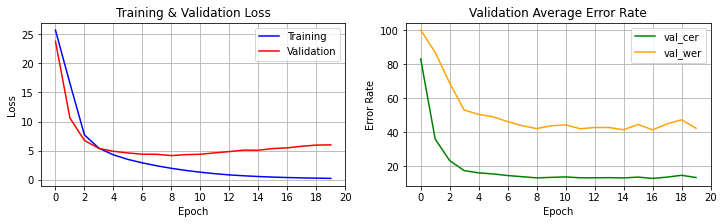

In [29]:
show_history(history)

- 9 epoch 쯤에서 Validation Loss가 상승하기 시작했고, 에러율이 수렴했다.
- 17 epoch에서 에려율이 가장 낮았다.

|epoch|9|17|
|-|-|-|
|loss|1.9985|0.4200|
|val_loss|4.1792|5.5073|
|Validation CER|13.29%|12.99%|
|Validation WER|42.24%|41.48%|

## Test set에 대한 성능 평가

학습 시 Val loss가 가장 낮았던 9 epoch 모델과, 에러율이 가장 낮았던 17 epoch 모델의 test set에 대한 에러율 확인

In [63]:
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

In [64]:
def evaluate_model(ckpt_path, dataset=test_set, return_model=False):
    
    # 모델 재정의
    test_model = build_crnn_model()
    test_model.load_weights(ckpt_path)
    
    input_data = test_model.get_layer('input_image').output
    y_pred = test_model.get_layer('output').output
    model_pred = Model(inputs=input_data, outputs=y_pred)
    
    # 라볠, 예측값 수집
    test_predictions_raw = []
    test_ground_truths_text = []

    for i in range(len(dataset)):
        inputs, _ = dataset[i]
        batch_images = inputs['input_image']
        batch_labels_encoded = inputs['label']
        batch_label_length = inputs['label_length']

        batch_output = model_pred.predict(batch_images, verbose=0)

        decoded_preds_batch = decode_predict_ctc(batch_output, characters="-" + TARGET_CHARACTERS)
        test_predictions_raw.extend(decoded_preds_batch)

        for j in range(batch_labels_encoded.shape[0]):
            gt_label_encoded = batch_labels_encoded[j][:batch_label_length[j]]
            gt_text = label_converter.decode(gt_label_encoded).replace('-', '')
            test_ground_truths_text.append(gt_text)

    # 최종 WER 및 CER 계산
    final_test_cer, final_test_wer = calculate_wer_cer(test_ground_truths_text, test_predictions_raw)

    print(f'Test Set Error Rate [{ckpt_path.split("/")[-1]}]')
    print(f'Total Test Samples: {len(test_ground_truths_text)}')
    print(f'Test CER: {final_test_cer:.2f}%')
    print(f'Test WER: {final_test_wer:.2f}%')
    print("="*77)
    
    if return_model:
        return test_model, model_pred

In [77]:
evaluate_model('./ckpt/baseline_epoch_9.hdf5')

Test Set Error Rate [baseline_epoch_9.hdf5]
Total Test Samples: 8960
Test CER: 13.08%
Test WER: 41.71%


In [81]:
model, model_pred = evaluate_model('./ckpt/baseline_epoch_17.hdf5', return_model=True)

Test Set Error Rate [baseline_epoch_17.hdf5]
Total Test Samples: 8960
Test CER: 12.98%
Test WER: 41.40%


- Test Set에 대한 에러율 확인 결과 17 epoch 모델의 에러율이 더 낮으므로 해당 모델을 Baseline Model로 선정하여 이후 과정 진행.
- Baseline 모델의 Test set 평가 결과:
    - 과반수(58.29%)의 단어를 정확하게 예측했다.
    - 나머지 41.4%의 샘플에 문자 에러율이 13% 미만으 약 87%의 정확도를 보였다.

# Detection Model 준비

In [96]:
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [101]:
def detect_text(img_path):
    # 이미지 읽기
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경
    img_add_dim = np.expand_dims(img, axis=0)
    
    # 배치의 첫 번째 결과 저장.
    ocr_result = detector.detect(img_add_dim)[0]
    
    # 시각화
    img_pil = Image.fromarray(img).copy()
    img_draw = ImageDraw.Draw(img_pil)
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))

    return img_pil, cropped_imgs

In [85]:
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수
- keras-ocr의 Detector를 이용
- inference한 후에는 이를 시각화
- 단어의 영역을 잘라서 저장

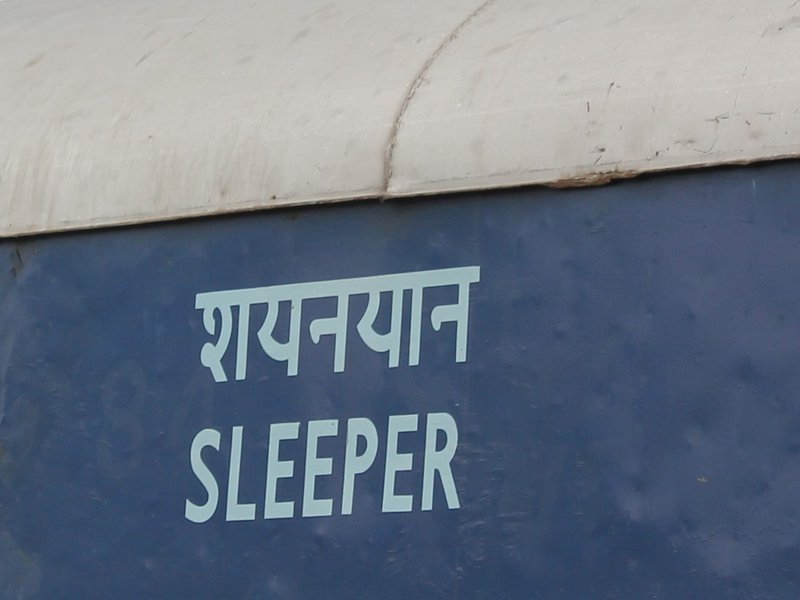

[이미지 원본]

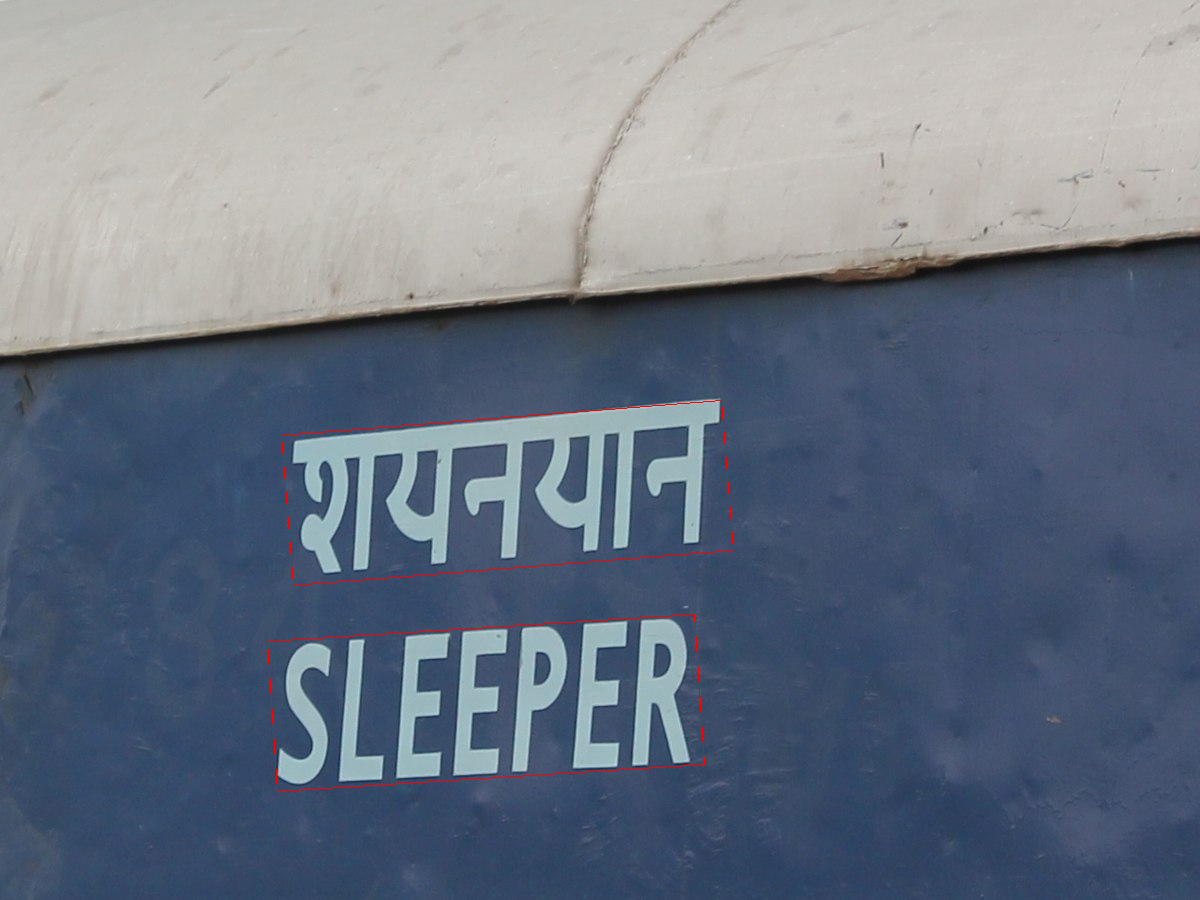

In [86]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

[Inference 결과 시각화]

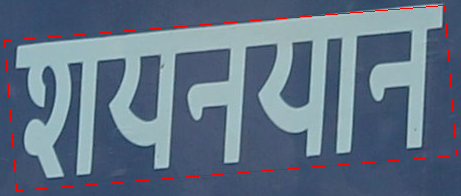

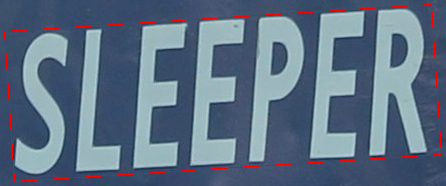

In [87]:
for cropped in cropped_img:
    display(cropped)

[단어 영역 잘라서 저장한 결과]

# Detection Model + Recognition Model

## 잘라낸 이미지에 대한 Recognition Model 작동 확인

위에서 회득한 이미지 내의 단어 영역 이미지를 Recognition model로 인식하는 함수

In [110]:
def recognize_img(pil_img, input_img_size=(100,32), show_cropped=True, print_text=True):
    img = np.array(pil_img.resize(input_img_size)).transpose(1,0,2)
    img = np.expand_dims(img, axis=0)
    output = model_pred.predict(img)
    result = decode_predict_ctc(output) #[0].replace('-','')
    if print_text: print("Recognized Text:", result)
    if show_cropped: display(pil_img)
    return result

Recognized Text: ['TEREFI']


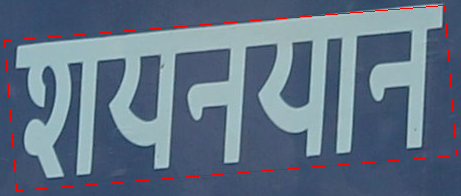

Recognized Text: ['SLEEPER']


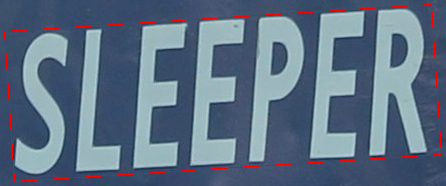

In [120]:
for _img in cropped_img:
    recognize_img(_img)

## OCR 함수

- Detection Model + Recognition Model이 결합되어 이미지를 입력하면 OCR 수행 결과를 리턴하는 함수.

In [121]:
def apply_OCR(img_path, show_bbox=False, show_cropped=False, print_text=False):
    img_pil, cropped_img = detect_text(img_path)
    if show_bbox: display(img_pil)
    results = []
    for _img in cropped_img:
        results.append(recognize_img(_img,
                                     show_cropped=show_cropped,
                                     print_text=print_text))
    return results

- OCR 함수 작동 확인

In [122]:
apply_OCR(SAMPLE_IMG_PATH)

[['TEREFI'], ['SLEEPER']]

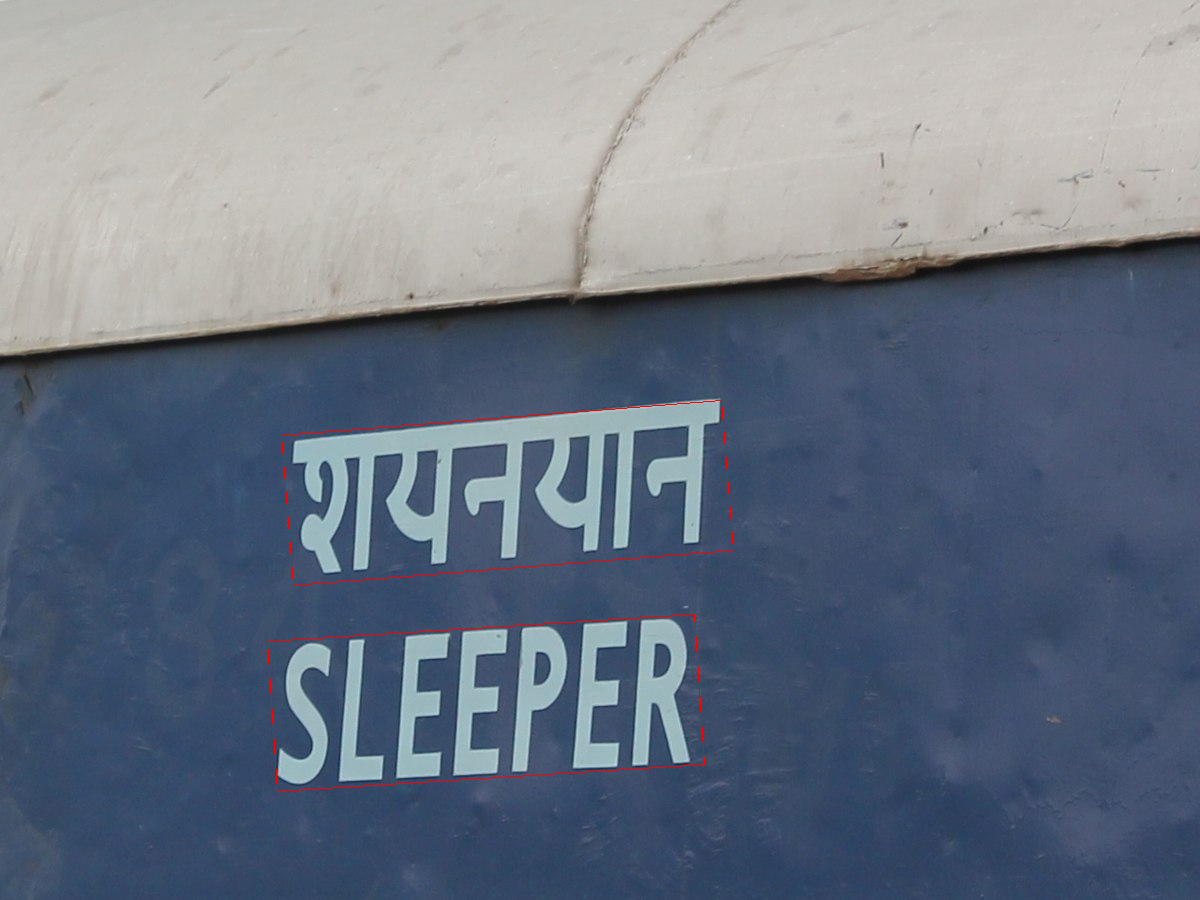

[['TEREFI'], ['SLEEPER']]

In [123]:
apply_OCR(SAMPLE_IMG_PATH, True)

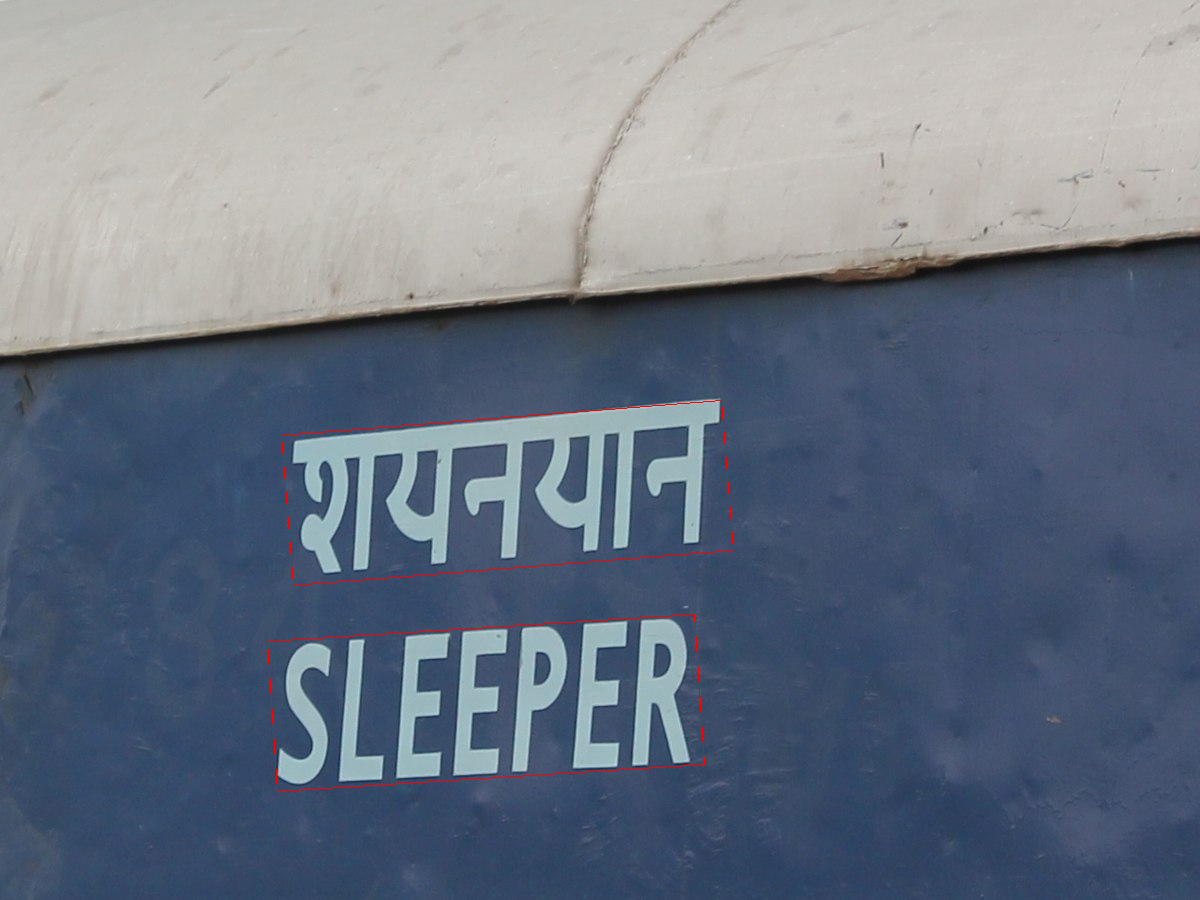

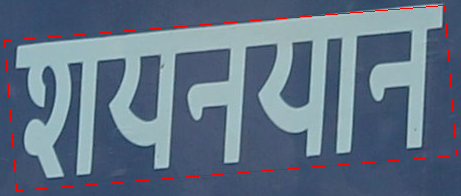

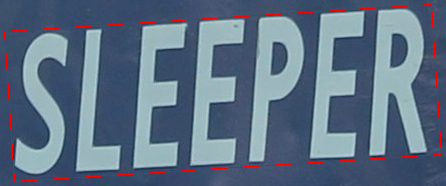

[['TEREFI'], ['SLEEPER']]

In [124]:
apply_OCR(SAMPLE_IMG_PATH, True, True)

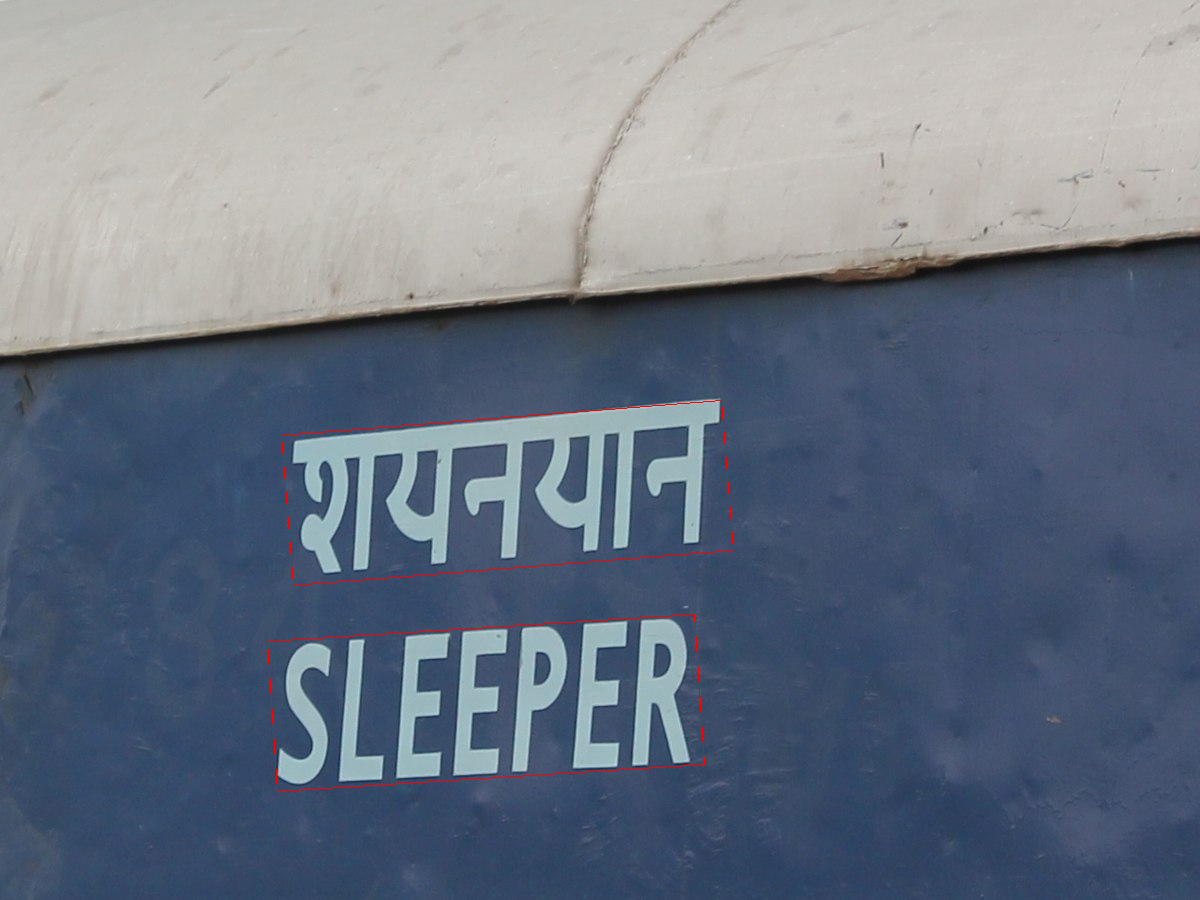

Recognized Text: ['TEREFI']


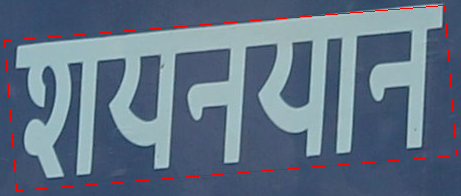

Recognized Text: ['SLEEPER']


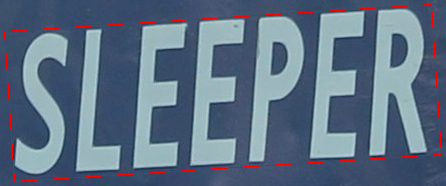

[['TEREFI'], ['SLEEPER']]

In [125]:
apply_OCR(SAMPLE_IMG_PATH, True, True, True)

Recognized Text: ['TEREFI']


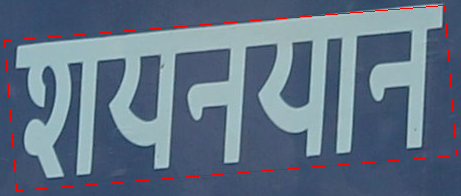

Recognized Text: ['SLEEPER']


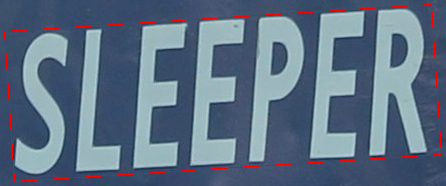

[['TEREFI'], ['SLEEPER']]

In [126]:
apply_OCR(SAMPLE_IMG_PATH, False, True, True)

In [127]:
results = apply_OCR(SAMPLE_IMG_PATH, False, False, True)

Recognized Text: ['TEREFI']
Recognized Text: ['SLEEPER']


In [128]:
results

[['TEREFI'], ['SLEEPER']]

# 추가 1. 패딩 오류 디버깅

기존 코드에서 인식 결과 출력 후 단어 최대 길이(24)만큼 숫자 `9`로 채우는 오류 발견

In [132]:
def error_decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

In [138]:
def error_recognize_img(pil_img, input_img_size=(100,32)):
    img = np.array(pil_img.resize(input_img_size)).transpose(1,0,2)
    img = np.expand_dims(img, axis=0)
    output = model_pred.predict(img)
    result = error_decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Recognized Text:", result)
    display(pil_img)
    return output

Recognized Text: SLEEPER9999999999999999


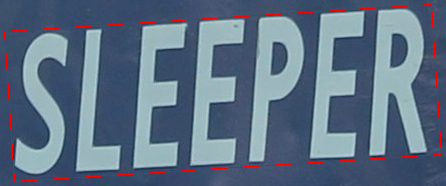

In [139]:
out = error_recognize_img(_img)

In [141]:
indexes = K.get_value(
    K.ctc_decode(
        out, input_length=np.ones(out.shape[0]) * out.shape[1],
        greedy=False , beam_width=5, top_paths=1
    )[0][0]
)[0]
indexes

array([19, 12,  5,  0,  5, 16,  5, 18, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])

- 확인 결과 `K.get_value()`를 통해 decode를 하는 과정에서 인식한 문자 외에 최대 길이까지 남은 공간은 `-1`로 채워서 return하는 것을 확인.

```
text = ""
for index in indexes:
    text += chars[index]
```

- 이후 해당 인덱스 값을 이용해 TARGET_CHARACTERS에서 해당 문자 하나씩 가져오는데, `-1` 인덱스에 해당하는 숫자 9가 계속 추가되도록 코드가 진행됨.

- 이를 수정하기 위해 `for문`에서 index가 `-1`인 경우는 문자를 가져오지 않고 해당 회차 loop를 넘어가도록 수정하여 무의미한 패딩값이 반환되지 않도록 함.

```
        text = ""
        for index in sequence:
            # CTC 디코딩 시 -1은 패딩을 의미 무의미한 "999"는 추가 안함
            if index == -1: 
                continue
            text += characters[index]
```

# 추가 2. 케라스 Recognizer

In [145]:
recognizer = Recognizer()

Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


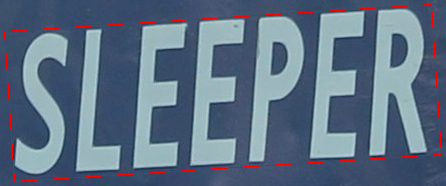

In [151]:
cropped

In [175]:
sample_test= np.array(cropped)
result = recognizer.recognize(sample_test)
result.upper()

'SLEEPER'

In [185]:
output = model_pred.predict(np.expand_dims(test_set[0][0]['input_image'][0], axis=0))
result = decode_predict_ctc(output)
result

['SLINKING']

In [187]:
result = recognizer.recognize(test_set[0][0]['input_image'][0].transpose(1,0,2))
result.upper()

'SLINKING'

In [197]:
# 라볠, 예측값 수집
test_predictions_raw = []
test_ground_truths_text = []

for i in range(len(test_set)):
    inputs, _ = test_set[i]
    batch_images = inputs['input_image']
    batch_labels_encoded = inputs['label']
    batch_label_length = inputs['label_length']

    for batch_image in batch_images:
        decoded_preds_batch = recognizer.recognize(batch_image.transpose(1,0,2)).upper()

        test_predictions_raw.append(decoded_preds_batch)

    for j in range(batch_labels_encoded.shape[0]):
        gt_label_encoded = batch_labels_encoded[j][:batch_label_length[j]]
        gt_text = label_converter.decode(gt_label_encoded).replace('-', '')
        test_ground_truths_text.append(gt_text)

# 최종 WER 및 CER 계산
final_test_cer, final_test_wer = calculate_wer_cer(test_ground_truths_text, test_predictions_raw)

print(f'Test Set Error Rate of Keras OCR Recognizer')
print(f'Total Test Samples: {len(test_ground_truths_text)}')
print(f'Test CER: {final_test_cer:.2f}%')
print(f'Test WER: {final_test_wer:.2f}%')
print("="*77)

Test Set Error Rate of Keras OCR Recognizer
Total Test Samples: 8960
Test CER: 4.81%
Test WER: 16.01%


- 에러율이 직접 훈련한 모델에 비해 상당히 낮은 것을 확인했다.
- Keras에서 제공하는 모델이 당연히 더 다양하고 많은 데이터를 학습했고 최적화가 잘 돼있겠지만, 하이퍼 파라미터 튜닝만으로도 충분히 성능 개선의 여지가 있을 것으로 보인다.

# 추가 3. 하이퍼 파라미터 튜닝

Test Set Error Rate [baseline_epoch_17.hdf5]  
Total Test Samples: 8960  
Test CER: 12.98%  
Test WER: 41.40%  

- Baseline Model의 성능(에러율) 개선을 위한 하이퍼 파라미터 튜닝

## Optimizer: Adam

In [13]:
# Model build
model = build_crnn_model()

# Inference 전용 모델 호출
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [14]:
# Model Compile
# optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=5.0)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1)

ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CKPT_PATH, "Adam_lr1e4" + "_ep_{epoch}.hdf5"),
    monitor="val_loss",
    save_best_only=False,
    save_weights_only=True,
    verbose=1)

wer_cer_monitor = WER_CER_Monitor(
    model_pred=model_pred, # 추론용 모델 전달
    val_set=val_set,       # 검증 데이터셋 시퀀스 전달
    label_converter=label_converter,    # 라벨 컨버터 전달
    chars=TARGET_CHARACTERS)            # 전체 문자 집합 전달

EPOCH = 20

In [15]:
Adam_lr1e4_history = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=EPOCH,
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, wer_cer_monitor, earlystop])

Epoch 1/20
565/565 [==============================] - 690s 1s/step - loss: 25.0453 - val_loss: 23.5359

Epoch 00001: saving model to /aiffel/aiffel/ocr/ckpt/Adam_lr1e4_ep_1.hdf5

[Epoch 1]Validation CER: 80.23% // Validation WER: 100.00%
----------------------------------------------------------------------
Epoch 2/20
565/565 [==============================] - 80s 142ms/step - loss: 15.3597 - val_loss: 10.2735

Epoch 00002: saving model to /aiffel/aiffel/ocr/ckpt/Adam_lr1e4_ep_2.hdf5

[Epoch 2]Validation CER: 34.15% // Validation WER: 85.18%
----------------------------------------------------------------------
Epoch 3/20
565/565 [==============================] - 81s 143ms/step - loss: 7.8724 - val_loss: 7.1008

Epoch 00003: saving model to /aiffel/aiffel/ocr/ckpt/Adam_lr1e4_ep_3.hdf5

[Epoch 3]Validation CER: 23.39% // Validation WER: 67.60%
----------------------------------------------------------------------
Epoch 4/20
565/565 [==============================] - 80s 142ms/step - lo

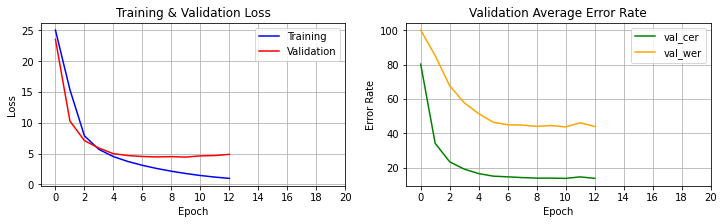

In [18]:
show_history(Adam_lr1e4_history)

- Adadelta와 유사한 방식인 Adam으로 변경한 결과, 유사한 양상을 보임.

- Adadelta때와는 달리 Early Stopping을 적용하여 13 epoch에서 학습을 종료.
    - 유사한 경향을 보이고 있으므로 이후 과정 확인이 굳이 필요 없음.
    - 이후 에러율이 다소 낮아지거나 하더라도 그 차이가 크지 않을 것으로 예상됨.
    
- 다만 Adadelta와는 달리 Adam은 Learning rate의 스케줄러 적용이 가능하므로 이를 통해 개선 여지가 남아있음.

## Optimizer: SGD

In [25]:
# Model build
sgd_model = build_crnn_model()

# Inference 전용 모델 호출
input_data = sgd_model.get_layer('input_image').output
y_pred = sgd_model.get_layer('output').output
sgd_model_pred = Model(inputs=input_data, outputs=y_pred)

# Model Compile
# optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, clipnorm=5.0)
sgd_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1)

ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CKPT_PATH, "SGD_lr1e2" + "_ep_{epoch}.hdf5"),
    monitor="val_loss",
    save_best_only=False,
    save_weights_only=True,
    verbose=1)

wer_cer_monitor = WER_CER_Monitor(
    model_pred=sgd_model_pred, # 추론용 모델 전달
    val_set=val_set,       # 검증 데이터셋 시퀀스 전달
    label_converter=label_converter,    # 라벨 컨버터 전달
    chars=TARGET_CHARACTERS)            # 전체 문자 집합 전달

EPOCH = 20

In [26]:
SGD_lr1e2_history = sgd_model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=EPOCH,
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, wer_cer_monitor, earlystop])

Epoch 1/20
565/565 [==============================] - 87s 144ms/step - loss: 26.1874 - val_loss: 26.2147

Epoch 00001: saving model to /aiffel/aiffel/ocr/ckpt/SGD_lr1e2_ep_1.hdf5

[Epoch 1]Validation CER: 82.93% // Validation WER: 100.00%
----------------------------------------------------------------------
Epoch 2/20
565/565 [==============================] - 80s 142ms/step - loss: 21.5409 - val_loss: 14.0547

Epoch 00002: saving model to /aiffel/aiffel/ocr/ckpt/SGD_lr1e2_ep_2.hdf5

[Epoch 2]Validation CER: 52.66% // Validation WER: 99.05%
----------------------------------------------------------------------
Epoch 3/20
565/565 [==============================] - 80s 142ms/step - loss: 6.4795 - val_loss: 5.0865

Epoch 00003: saving model to /aiffel/aiffel/ocr/ckpt/SGD_lr1e2_ep_3.hdf5

[Epoch 3]Validation CER: 16.83% // Validation WER: 50.93%
----------------------------------------------------------------------
Epoch 4/20
565/565 [==============================] - 80s 141ms/step - los

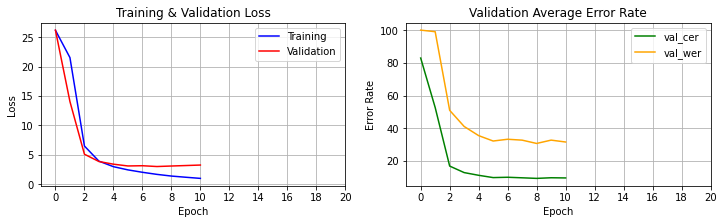

In [27]:
show_history(SGD_lr1e2_history)

- 별로 기대하지 않았던 SGD가 현재까지 가장 좋은 성능을 보였다.

- Adam에 비해 빠르게 수렴하고 loss 및 에러율이 더 적으므로 optimizer는 SGD를 사용하기로 한다.

- 해당 모델 역시 Learning Scheduler를 적용하여 개선 여지가 있어 보인다.

In [84]:
def get_records(history):
    print("최저 Val Loss 기록 epoch:", history.history['val_loss'].index(
        min(history.history['val_loss']))+1, "\t(",
          min(history.history['val_loss']),")")

    print("최저 Val 에러율 기록 epoch:", history.history['val_cer'].index(
        min(history.history['val_cer']))+1,
          "\n\t-val_cer:",min(history.history['val_cer']),
          "\n\t-val_wer:", min(history.history['val_wer']))

In [85]:
get_records(SGD_lr1e2_history)

최저 Val Loss 기록 epoch: 8 	( 2.9895482063293457 )
최저 Val 에러율 기록 epoch: 9 
	-val_cer: 9.291324256299847 
	-val_wer: 30.667162698412696


## SGD + LR scheduler(CosineDecay)

In [33]:
# Model build
sgd_lrs_model = build_crnn_model()

# Inference 전용 모델 호출
input_data = sgd_lrs_model.get_layer('input_image').output
y_pred = sgd_lrs_model.get_layer('output').output
sgd_lrs_model_pred = Model(inputs=input_data, outputs=y_pred)

# LR scheduler: CosineDecay
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.01,
    decay_steps= 20 * len(train_set),  # total_epochs * steps_per_epoch
    alpha=0.0)  # min learning rate ratio

# Model Compile
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, clipnorm=5.0)
sgd_lrs_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1)

ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CKPT_PATH, "SGD_lrs" + "_ep_{epoch}.hdf5"),
    monitor="val_loss",
    save_best_only=False,
    save_weights_only=True,
    verbose=1)

wer_cer_monitor = WER_CER_Monitor(
    model_pred=sgd_lrs_model_pred, # 추론용 모델 전달
    val_set=val_set,       # 검증 데이터셋 시퀀스 전달
    label_converter=label_converter,    # 라벨 컨버터 전달
    chars=TARGET_CHARACTERS)            # 전체 문자 집합 전달

EPOCH = 20

In [34]:
SGD_lrs_history = sgd_lrs_model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=EPOCH,
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, wer_cer_monitor, earlystop])

Epoch 1/20
565/565 [==============================] - 88s 145ms/step - loss: 26.1572 - val_loss: 25.6884

Epoch 00001: saving model to /aiffel/aiffel/ocr/ckpt/SGD_lrs_ep_1.hdf5

[Epoch 1]Validation CER: 86.78% // Validation WER: 100.00%
----------------------------------------------------------------------
Epoch 2/20
565/565 [==============================] - 81s 143ms/step - loss: 24.3705 - val_loss: 23.6513

Epoch 00002: saving model to /aiffel/aiffel/ocr/ckpt/SGD_lrs_ep_2.hdf5

[Epoch 2]Validation CER: 83.35% // Validation WER: 100.00%
----------------------------------------------------------------------
Epoch 3/20
565/565 [==============================] - 81s 142ms/step - loss: 10.1488 - val_loss: 6.3821

Epoch 00003: saving model to /aiffel/aiffel/ocr/ckpt/SGD_lrs_ep_3.hdf5

[Epoch 3]Validation CER: 22.19% // Validation WER: 65.84%
----------------------------------------------------------------------
Epoch 4/20
565/565 [==============================] - 81s 143ms/step - loss: 4

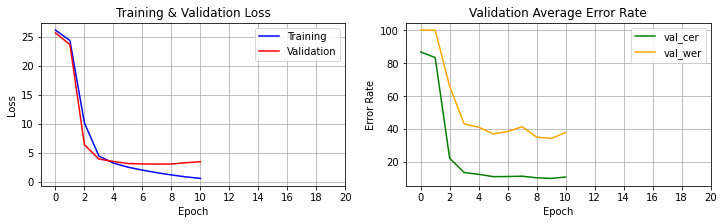

In [35]:
show_history(SGD_lrs_history)

- 최저 Validation loss 도달지점을 동일하지만 오히려 스케줄러를 적용하여 최저지점 loss도 상승하고, 에러율도 높아져 성능 저하 효과만 있었다.
    - Warmup 없이 적용된 것이 문제가 됐을 가능성이 있어 보인다.
    - Training loss가 스케줄러 적용 이후 비교적 꾸준히 감소하지만 Val loss가 상승하는 것으로 보아 과적합 효과만 가져온 것으로 보인다.
    
- 학습률을 꾸준히 감소시키는 방식이 아닌 정체구간에서 낮추는 방식으로 재시도 필요.

In [86]:
get_records(SGD_lrs_history)

최저 Val Loss 기록 epoch: 8 	( 3.0579562187194824 )
최저 Val 에러율 기록 epoch: 10 
	-val_cer: 10.01910422415623 
	-val_wer: 34.28819444444444


## SGD + LR scheduler(ReduceLROnPlateau)

In [38]:
# Model build
sgd_lrs_model2 = build_crnn_model()

# Inference 전용 모델 호출
input_data = sgd_lrs_model2.get_layer('input_image').output
y_pred = sgd_lrs_model2.get_layer('output').output
sgd_lrs_model_pred2 = Model(inputs=input_data, outputs=y_pred)

# 2. ReduceLROnPlateau 콜백 추가
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # 모니터링할 지표 (val_loss가 증가하면 학습률 감소)
    factor=0.5,          # 학습률을 줄일 비율 (new_lr = current_lr * factor)
    patience=1,          # val_loss가 개선되지 않으면 학습률 감소
    min_lr=1e-6,         # 최소 학습률
    verbose=1)           # 학습률이 감소할 때 메시지 출력

# Model Compile
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, clipnorm=5.0)
sgd_lrs_model2.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1)

ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CKPT_PATH, "SGD_lrs2" + "_ep_{epoch}.hdf5"),
    monitor="val_loss",
    save_best_only=False,
    save_weights_only=True,
    verbose=1)

wer_cer_monitor = WER_CER_Monitor(
    model_pred=sgd_lrs_model_pred2, # 추론용 모델 전달
    val_set=val_set,       # 검증 데이터셋 시퀀스 전달
    label_converter=label_converter,    # 라벨 컨버터 전달
    chars=TARGET_CHARACTERS)            # 전체 문자 집합 전달

EPOCH = 20

In [39]:
SGD_lrs_history2 = sgd_lrs_model2.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=EPOCH,
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, wer_cer_monitor, earlystop, reduce_lr])

Epoch 1/20
565/565 [==============================] - 87s 145ms/step - loss: 25.8699 - val_loss: 25.3464

Epoch 00001: saving model to /aiffel/aiffel/ocr/ckpt/SGD_lrs2_ep_1.hdf5

[Epoch 1]Validation CER: 81.00% // Validation WER: 99.99%
----------------------------------------------------------------------
Epoch 2/20
565/565 [==============================] - 81s 143ms/step - loss: 16.7281 - val_loss: 8.0994

Epoch 00002: saving model to /aiffel/aiffel/ocr/ckpt/SGD_lrs2_ep_2.hdf5

[Epoch 2]Validation CER: 28.24% // Validation WER: 77.83%
----------------------------------------------------------------------
Epoch 3/20
565/565 [==============================] - 81s 142ms/step - loss: 5.3023 - val_loss: 4.5263

Epoch 00003: saving model to /aiffel/aiffel/ocr/ckpt/SGD_lrs2_ep_3.hdf5

[Epoch 3]Validation CER: 16.67% // Validation WER: 53.57%
----------------------------------------------------------------------
Epoch 4/20
565/565 [==============================] - 80s 141ms/step - loss: 3.

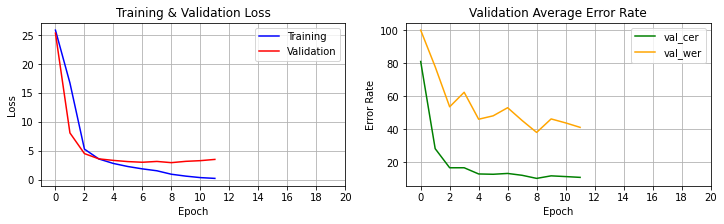

In [41]:
show_history(SGD_lrs_history2)

- Learning Rate 조절의 효과로 Training Loss가 감소하는 것은 Cosine Dacay에 이어서 재확인 되었으나 마찬가지로 Training Loss만 감소할 뿐 Validation loss는 오히려 증가한다.

- Val loss가 증가함에 따라 에러율이 함께 증가하는 모습이 확인됐다.

In [87]:
get_records(SGD_lrs_history2)

최저 Val Loss 기록 epoch: 9 	( 2.9611101150512695 )
최저 Val 에러율 기록 epoch: 9 
	-val_cer: 10.248051672377718 
	-val_wer: 38.070436507936506


# 모델 비교

In [132]:
def compare_history(history_list, focus='val_loss', y_lim=(-1, 10)):
    plt.figure(figsize=(12,12))

    for i in range(len(history_list)):
        plt.plot(history_list[i].history[focus])
    plt.title(focus)
    plt.ylabel(focus)
    plt.xlabel('Epoch')
    plt.legend(['baseline_model', 'Adam', 'SGD', 'SGD+CosDecay', 'SGD+RLRP'])
    plt.grid(True)
    plt.ylim(y_lim)
    plt.xlim(-1, 20)
    plt.xticks(range(0, 21, 2))
    plt.show()

In [71]:
top_models = ['SGD_lrs2_ep_9.hdf5', 'SGD_lr1e2_ep_8.hdf5', 'SGD_lr1e2_ep_9.hdf5']
for model_name in top_models:
    evaluate_model('./ckpt/' + model_name)

Test Set Error Rate [SGD_lrs2_ep_9.hdf5]
Total Test Samples: 8960
Test CER: 10.16%
Test WER: 37.91%
Test Set Error Rate [SGD_lr1e2_ep_8.hdf5]
Total Test Samples: 8960
Test CER: 9.46%
Test WER: 32.12%
Test Set Error Rate [SGD_lr1e2_ep_9.hdf5]
Total Test Samples: 8960
Test CER: 9.07%
Test WER: 30.03%


In [72]:
evaluate_model('./data/model_checkpoint.hdf5')

Test Set Error Rate [model_checkpoint.hdf5]
Total Test Samples: 8960
Test CER: 13.12%
Test WER: 43.15%


|Model|Epoch|Val Loss|Test Avg CER|Test Avg WER|
|-|-|-|-|-|
|Baseline(Adadelta)|17|5.50|12.98%|41.40%|
|17번 노드 모델|N/A|N/A|13.12% (+0.14%p)|43.15% (+1.75%p)|
|SGD+ReduceLROnPlateau|9|2.96|10.16% (-2.82%p)|37.91% (+3.49%p)|
|SGD|8|2.99%|9.46% (-3.52%p)|32.12% (-9.28%p)|
|SGD|9|3.08%|9.07% (-3.91%p)|30.03% (-11.37%p)|
|Keras_OCR|N/A|N/A|4.81 (-8.17%p)|16.01% (-25.39%p)|

In [101]:
history_list = [baseline_model, Adam_lr1e4_history,
                SGD_lr1e2_history, SGD_lrs_history, SGD_lrs_history2]

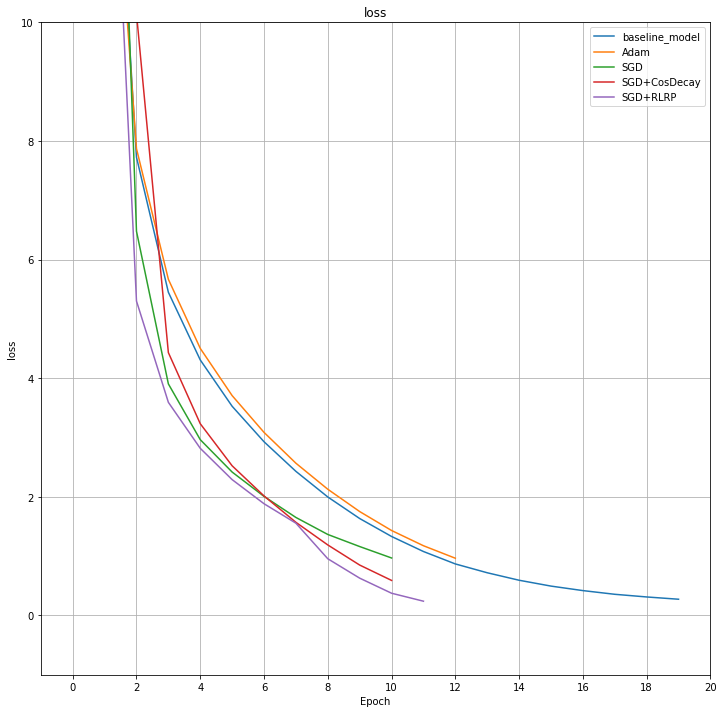

In [133]:
compare_history(history_list, 'loss')

- Baseline model(Adadelta)과 Adam 모델은 Training loss 변화가 매우 유사한 양상을 보인다. 단, Adam 모델이 비교적 높다.

- SGD 모델들은 Learning Rate을 조절하여 Training loss가 개선되는 모습이 보인다.

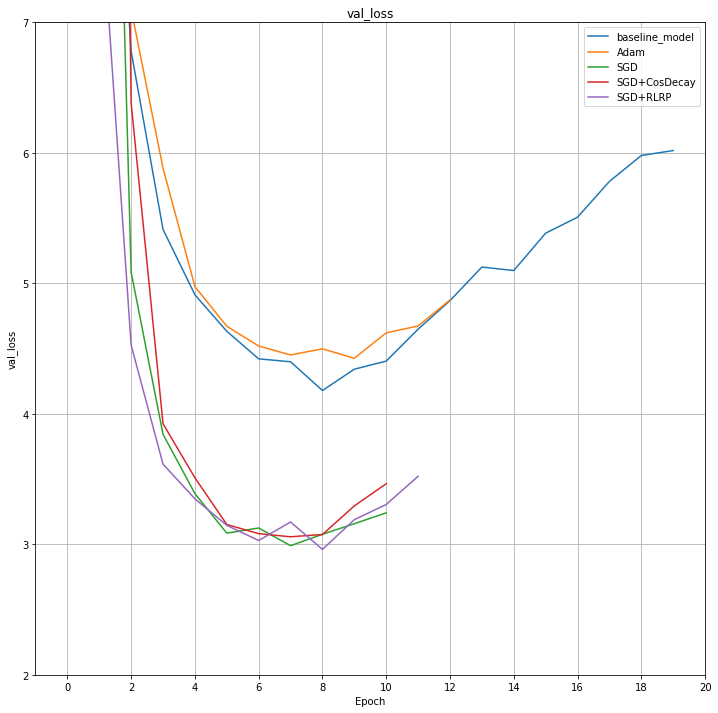

In [136]:
compare_history(history_list, 'val_loss', (2, 7))

- Baseline model(Adadelta)과 Adam 모델은 Validation loss 변화 역시 매우 유사한 양상을 보인다. 단, Adam 모델이 비교적 높다.

- SGD 모델들의 경우, 학습률을 조절한 모델들이 조절하지 않은 모델에 비해 Validation loss가 비슷한은 상태를 유지하다 과적합 지점부터 상대적으로 더욱 빠르게 증가한다.
    - 결과적으로 validation loss의 개선은 되지 않았다.

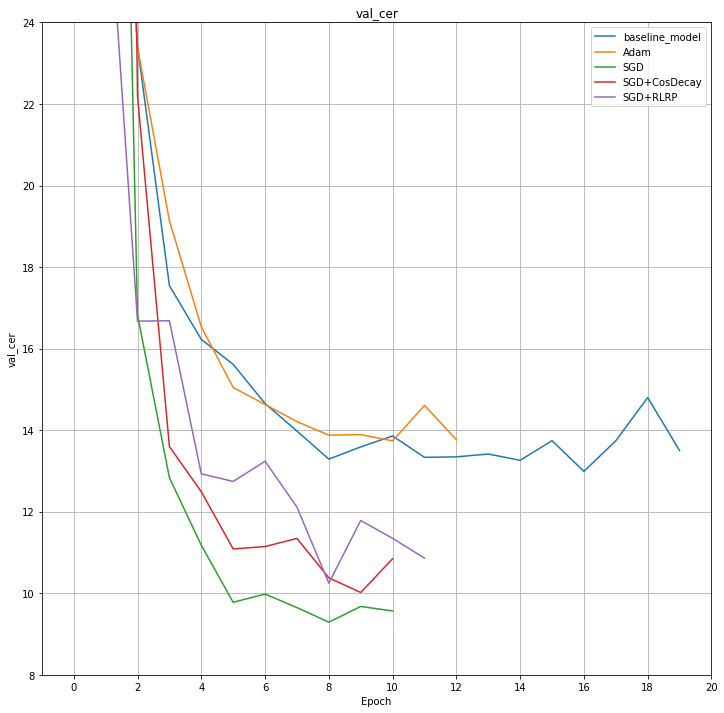

In [141]:
compare_history(history_list, 'val_cer', (8, 24))

- Validation 문자 에러율의 경우에도 Adam과 baseline(Adadelta)s는 유사한 경향을 보인다. 단, Adam 모델이 비교적 높다.

- SGD 모델들은 learning rate을 조절한 모델들이 그렇지 않은 모델에 비해 높은 에러율을 보인다.

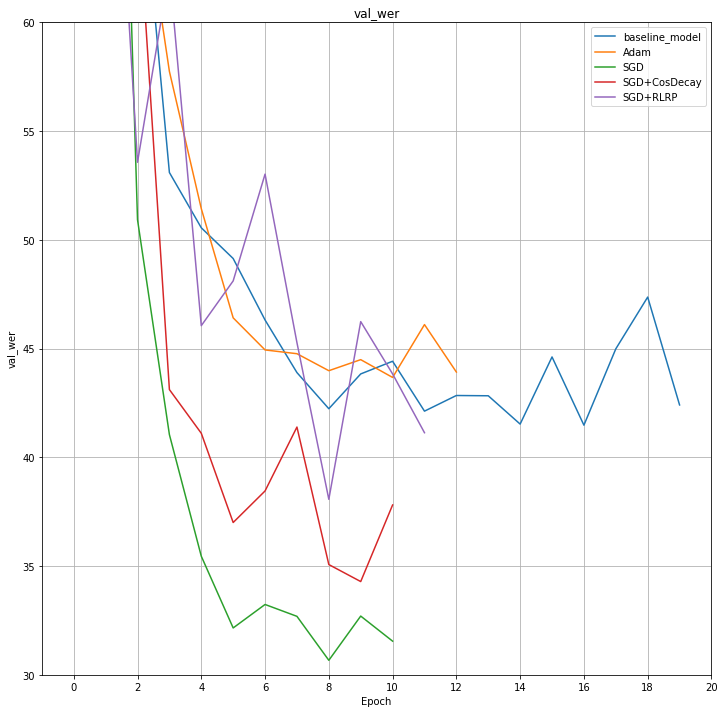

In [144]:
compare_history(history_list, 'val_wer', (30, 60))

- Validation 단어 에러율의 경우에도 Adam과 baseline(Adadelta)s는 유사한 경향을 보인다. 단, Adam 모델이 비교적 높은 경우가 많다.

- SGD 모델들은 learning rate을 조절한 모델들이 그렇지 않은 모델에 비해 높은 에러율을 보인다.
    - 조절한 모델들이 그렇지 않은 모델에 비해 에러율이 요동치는 폭이 더 큰 모습도 관측되었다.
    - ReduceLROnPlateau이 적용된 모델이 그 진동폭이 가장 크지만 8 epoch 이전에는 적용하지 않은 모델과 같은 학습률을 유지한다는 점에서 이유를 파악하기 어렵다.

# 회고

- OCR 기술이 단순히 문자를 학습시킨 Detection 모델 정도로만 생각했는데 시퀀스 예측 과정까지 진행되는 좀 더 복잡한 기술이라는 점이 신기했다. 또한, 이를 직접 구현해보며 이해하게 되는 시간이었다는 점에서 좋았다.

- 이번 프로젝트에서 사용한 데이터와 모델 구조에서는 모델 학습 시간이 비교적 짧아서 여러 실험을 진행하기 위한 시간을 할애할 수 있어서 좋았다.

- Optimizer의 경우 "잘 모르겠을 때는 `Adam`을 사용해라. 웬만하면 잘 맞는다"는 말을 어디서 본 적이 있는데, 이번에 그 웬만하지 않은 경우를 만난 것 같아서 재미있었다.

- 더 이상 Loss의 개선이 되지 않을 때, Learning Rate를 조절하면 해결할 수 있거나 최소한 더 나빠지지는 않는다고 믿었었다. 그러나 이번 경험을 통해 그렇게 개선되는 loss가 train set에 한정되어 더욱 과적합이 되는 등 부정적 영향이 줄 수도 있다는 교훈을 얻은 시간이었다.

---